<a href="https://colab.research.google.com/github/MySureStart/mit-futuremakers-summer-2024-faefey/blob/main/Module_16_Computer_Vision_and_GANs/Computer_Vision_and_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

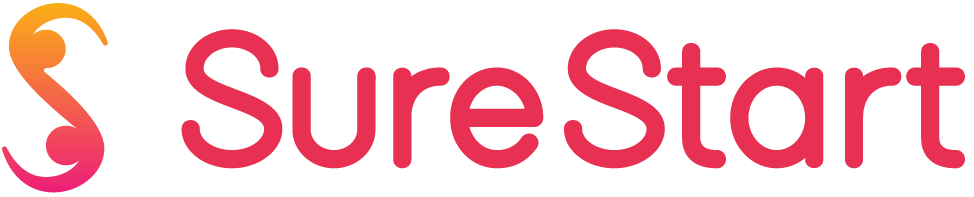

#Objectives
* Introduction to Computer Vision (CV) to understand how machines “see” the visual world.
* Learn how machines can “read” your emotions by looking at your face.

#Computer Vision
Computer vision is a field of artificial intelligence (AI) that enables computers and systems to derive meaningful information from digital images, videos and other visual inputs — and take actions or make recommendations based on that information. If AI enables computers to think, computer vision enables them to see, observe and understand.

Computer vision works much the same as human vision, except humans have a head start. Human sight has the advantage of lifetimes of context to train how to tell objects apart, how far away they are, whether they are moving and whether there is something wrong in an image.

Computer vision trains machines to perform these functions, but it has to do it in much less time with cameras, data and algorithms rather than retinas, optic nerves and a visual cortex. Because a system trained to inspect products or watch a production asset can analyze thousands of products or processes a minute, noticing imperceptible defects or issues, it can quickly surpass human capabilities.


In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

<ipython-input-1-4617c670b37f>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Talking about GANs in Computer Vision
GANs are a form of neural network in which two sub-networks (the encoder and decoder) are trained on opposing loss functions: an encoder that is trained to produce data which is indiscernable from the true data, and a decoder that is trained to discern between the data and generated data.

### Load fashion-MNIST dataset

In [2]:
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28,28,1)
N_TRAIN_BATCHES = int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [3]:
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Question 1
We have used both numpy array/pandas dataframe and tensorflow datasets. What is the difference in using either to train a model?

### Answer 1

The difference is that training using a NumPy array or Pandas dataframe usually requires the entire dataset to fit in memory. Tensorflow datasets can still be used even if they cannot fit in memory, making them more suitable for very large datasets.

# Define the network architecture

In supervised learning, we may be interested in developing a model to predict a class label given an example of input variables.

This predictive modeling task is called classification.

Classification is also traditionally referred to as discriminative modeling.

This is because a model must discriminate examples of input variables across classes; it must choose or make a decision as to what class a given example belongs. Alternately, unsupervised models that summarize the distribution of input variables may be able to be used to create or generate new examples in the input distribution.

The GAN model architecture involves two sub-models: a generator model for generating new examples and a discriminator model for classifying whether generated examples are real, from the domain, or fake, generated by the generator model.

* **Generator**: Model that is used to generate new plausible examples from the problem domain.
* **Discriminator**: Model that is used to classify examples as real (from the domain) or fake (generated).





## Question 2
Implement a **discriminator**.

The discriminator model takes an example from the domain as input (real or generated) and predicts a binary class label of real or fake (generated).

The real example comes from the training dataset. The generated examples are output by the generator model.

The discriminator is a well understood classification model which we have already worked on through CNNs.

After the training process, the discriminator model is discarded as we are interested in the generator.

Sometimes, the generator can be repurposed as it has learned to effectively extract features from examples in the problem domain. Some or all of the feature extraction layers can be used in transfer learning applications using the same or similar input data.

### Answer 2

Create the discriminator. It maps a 28x28 image to a binary classification score.


In [4]:
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), strides=(2, 2), padding="same", activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, (3,3), strides=(2, 2), padding="same", activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ], name="discriminator")
discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         200,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 210,529 (822.38 KB)

 Trainable params: 210,529 (822.38 KB)

 Non-trainable params: 0 (0.00 B)

## Question 3
Implement a **generator**.

The generator model takes a fixed-length random vector as input and generates a sample in the domain.

The vector is drawn randomly from a Gaussian distribution, and the vector is used to seed the generative process. After training, points in this multidimensional vector space will correspond to points in the problem domain, forming a compressed representation of the data distribution.

This vector space is referred to as a latent space, or a vector space comprised of latent variables. Latent variables, or hidden variables, are those variables that are important for a domain but are not directly observable.

We often refer to latent variables, or a latent space, as a projection or compression of a data distribution. That is, a latent space provides a compression or high-level concepts of the observed raw data such as the input data distribution. In the case of GANs, the generator model applies meaning to points in a chosen latent space, such that new points drawn from the latent space can be provided to the generator model as input and used to generate new and different output examples.



### Answer 3
Create the generator. It mirrors the discriminator, replacing Conv2D layers with Conv2DTranspose layers.

In [5]:
latent_dim = 64

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7*7*32, activation='relu', input_shape=(latent_dim,)),
    tf.keras.layers.Reshape((7, 7, 32)),
    tf.keras.layers.Conv2DTranspose(32, (3,3), strides=(1, 1), padding="same", activation='relu'),
    tf.keras.layers.Conv2DTranspose(32, (3,3), strides=(2, 2), padding="same", activation='relu'),
    tf.keras.layers.Conv2DTranspose(1, (3,3), strides=(2, 2), padding="same", activation='sigmoid')
    ], name="generator")
generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 1568)                │         101,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,705 (471.50 KB)

 Trainable params: 120,705 (471.50 KB)

 Non-trainable params: 0 (0.00 B)

#Generative vs. Discriminative Algorithms
To understand GANs, you should know how generative algorithms work, and for that, contrasting them with discriminative algorithms is instructive. Discriminative algorithms try to classify input data; that is, given the features of an instance of data, they predict a label or category to which that data belongs.

For example, given all the words in an email (the data instance), a discriminative algorithm could predict whether the message is spam or not_spam. spam is one of the labels, and the bag of words gathered from the email are the features that constitute the input data. When this problem is expressed mathematically, the label is called y and the features are called x. The formulation p(y|x) is used to mean “the probability of y given x”, which in this case would translate to “the probability that an email is spam given the words it contains.”

So discriminative algorithms map features to labels. They are concerned solely with that correlation. One way to think about generative algorithms is that they do the opposite. Instead of predicting a label given certain features, they attempt to predict features given a certain label.

The question a generative algorithm tries to answer is: Assuming this email is spam, how likely are these features? While discriminative models care about the relation between y and x, generative models care about “how you get x.” They allow you to capture p(x|y), the probability of x given y, or the probability of features given a label or category. (That said, generative algorithms can also be used as classifiers. It just so happens that they can do more than categorize input data.)

Another way to think about it is to distinguish discriminative from generative like this:

* Discriminative models learn the boundary between classes
* Generative models model the distribution of individual classes

## Question 4

Do you see any similartiy or dissimilarity between Autoencoders (Encoder - Decoder) and GANs (Discriminator - Generator)? Describe.

### Answer 4

Autoencoders and GANs are similar in that they are both composed of two major components that perform opposing tasks. The encoder "condenses" data into a more compressed form, while the discriminator "condenses" the data into decisions/classes. Both the decoder and generator attempts to "reconstruct" the original input. However, the goals of autoencoders, GANs, and their components are different from each other.

## Define the network as tf.keras.model object

Generative modeling is an unsupervised learning problem, as we discussed in the previous section, although a clever property of the GAN architecture is that the training of the generative model is framed as a supervised learning problem.

Let’s say we’re trying to do something more banal than mimic the Mona Lisa. We’re going to generate hand-written numerals like those found in the MNIST dataset, which is taken from the real world. The goal of the discriminator, when shown an instance from the true MNIST dataset, is to recognize those that are authentic.

Meanwhile, the generator is creating new, synthetic images that it passes to the discriminator. It does so in the hopes that they, too, will be deemed authentic, even though they are fake. The goal of the generator is to generate passable hand-written digits: to lie without being caught. The goal of the discriminator is to identify images coming from the generator as fake.

Here are the steps a GAN takes:

* The generator takes in random numbers and returns an image.
* This generated image is fed into the discriminator alongside a stream of images taken from the actual, ground-truth dataset.
* The discriminator takes in both real and fake images and returns probabilities, a number between 0 and 1, with 1 representing a prediction of authenticity and 0 representing fake.

So you have a double feedback loop:

* The discriminator is in a feedback loop with the ground truth of the images, which we know.
* The generator is in a feedback loop with the discriminator.

Here the GAN model we use incorporates two different sub-models which requires us to calculate the loss for it in a different way explicitly. The  tf.keras.models.Sequential.fit() does not support this unless we structure that as tensorflow structures its loss functions.


In [6]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

# Train the model

Create a callback that periodically saves generated images

Callbacks can be passed to keras methods such as fit, evaluate, and predict in order to hook into the various stages of the model training and inference lifecycle.

To create a custom callback, subclass keras.callbacks.Callback and override the method associated with the stage of interest. See https://www.tensorflow.org/guide/keras/custom_callback for more information.

In [7]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

In [8]:
epochs = 1  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

gan.fit(
    train_dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

118/118 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - d_loss: 0.4855 - g_loss: 1.3191


While we can just train the model, we also want to see what the model is learning, run the below code to plot the generated images by the GAN.

In [9]:
# exampled data for plotting results
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.generator(tf.random.normal(shape=(BATCH_SIZE, latent_dim)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - d_loss: 0.0379 - g_loss: 4.2036


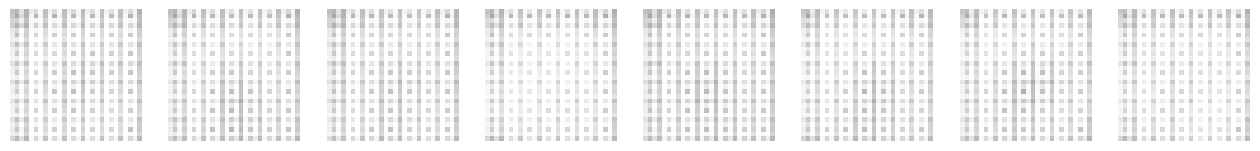

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.0356 - g_loss: 4.3375
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: 0.0414 - g_loss: 5.3625
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: 0.0487 - g_loss: 8.7087
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: 0.1576 - g_loss: 8.5684
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: 0.4236 - g_loss: 8.2168
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - d_loss: 0.0969 - g_loss: 8.4938
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: 0.0601 - g_loss: 8.6810
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: 0.0495 - g_loss: 7.5945
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.0270 - g_loss: 8.0015
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: 0.0100 - g_loss: 8.6185


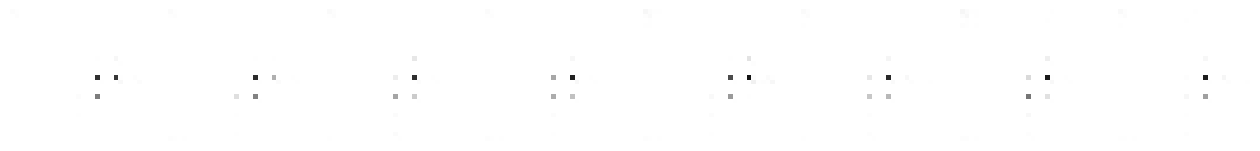

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - d_loss: -0.0060 - g_loss: 9.3886
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: -0.0242 - g_loss: 10.5661
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: -0.0433 - g_loss: 12.0602
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: -0.0676 - g_loss: 13.9706
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.4125 - g_loss: 9.7302
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: 0.0224 - g_loss: 15.9454
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - d_loss: -0.1518 - g_loss: 26.0092
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.0848 - g_loss: 5.3629
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: 0.0361 - g_loss: 7.5444
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: -0.0082 - g_loss: 10.2545


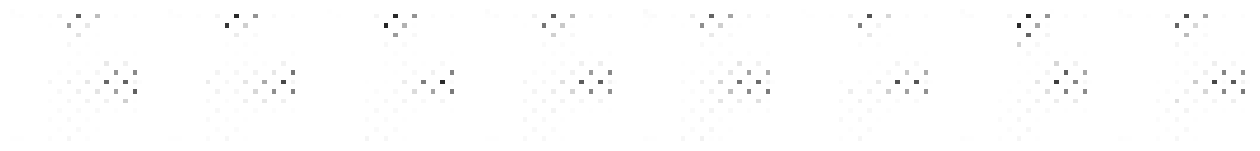

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - d_loss: -0.0281 - g_loss: 11.7880
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - d_loss: -0.0506 - g_loss: 13.6581
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: -0.0816 - g_loss: 15.9481
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1566 - g_loss: 14.4588
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.0228 - g_loss: 9.7993
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: -0.0264 - g_loss: 11.7748
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: -0.0545 - g_loss: 13.7579
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - d_loss: -0.0835 - g_loss: 16.3109
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: -0.1152 - g_loss: 19.7377
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: -0.1570 - g_loss: 23.6117


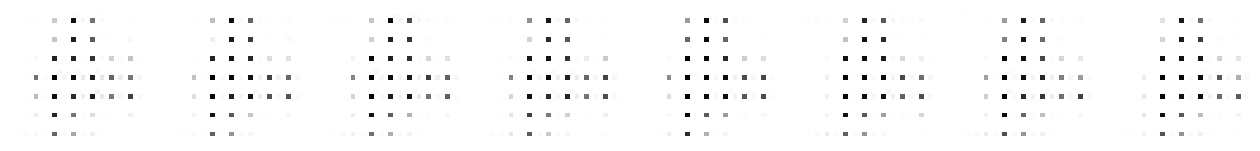

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - d_loss: -0.1614 - g_loss: 24.1235
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - d_loss: -0.2037 - g_loss: 28.1976
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: -0.2718 - g_loss: 35.0356
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - d_loss: -0.3137 - g_loss: 39.8275
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: -0.1505 - g_loss: 40.0450
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: 1.4551 - g_loss: 4.5451
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: 0.1590 - g_loss: 4.2488
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: 0.2297 - g_loss: 3.3518
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - d_loss: 0.0695 - g_loss: 5.2051
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1133 - g_loss: 4.1995


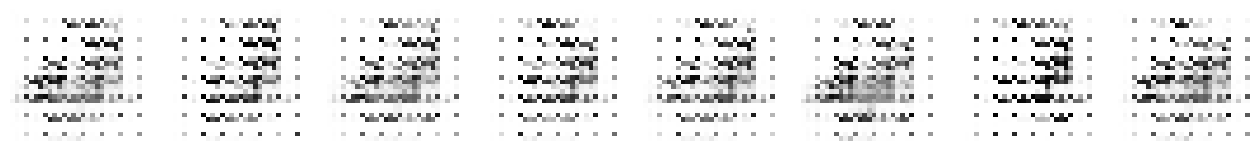

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - d_loss: 0.1086 - g_loss: 3.9590
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.0661 - g_loss: 5.3902
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - d_loss: 0.1056 - g_loss: 4.1972
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - d_loss: 0.1261 - g_loss: 3.6634
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1933 - g_loss: 3.0578
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.2000 - g_loss: 3.3189
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1285 - g_loss: 3.4136
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1863 - g_loss: 3.1257
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1986 - g_loss: 2.9152
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - d_loss: 0.1857 - g_loss: 2.8587


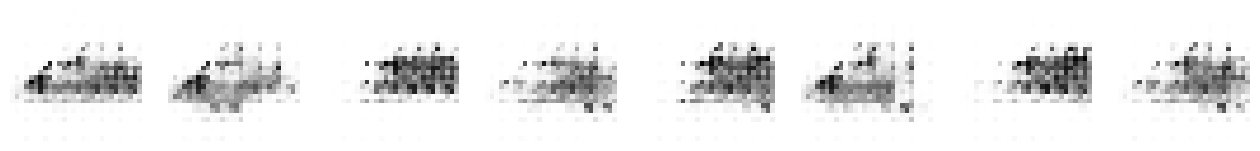

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - d_loss: 0.2197 - g_loss: 2.5441
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.2189 - g_loss: 2.5493
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1788 - g_loss: 2.7610
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - d_loss: 0.1899 - g_loss: 3.1042
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1860 - g_loss: 3.2598
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1042 - g_loss: 4.2228
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1963 - g_loss: 2.8152
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1721 - g_loss: 2.9675
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1922 - g_loss: 2.7084
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - d_loss: 0.1054 - g_loss: 3.4870


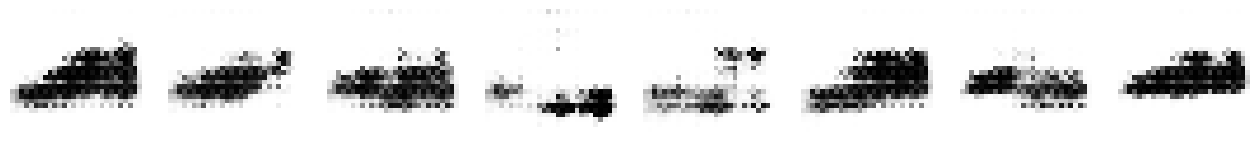

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - d_loss: 0.1997 - g_loss: 2.8402
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1223 - g_loss: 3.3677
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.2491 - g_loss: 2.9991
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1847 - g_loss: 2.8169
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.2298 - g_loss: 2.6994
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - d_loss: 0.2200 - g_loss: 2.4571
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - d_loss: 0.2251 - g_loss: 2.4809
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1883 - g_loss: 2.5595
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1733 - g_loss: 2.7920
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1937 - g_loss: 2.7023


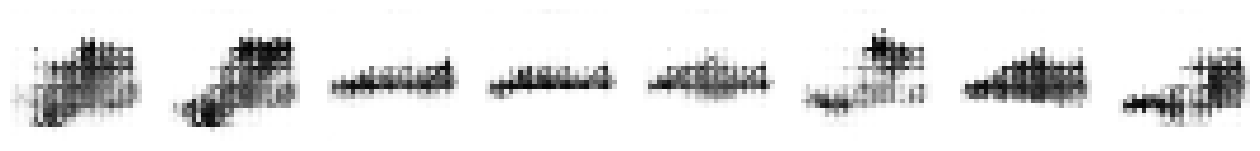

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - d_loss: 0.2126 - g_loss: 2.7701
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1839 - g_loss: 3.1353
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - d_loss: 0.1883 - g_loss: 2.9342
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1938 - g_loss: 2.7781
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.2252 - g_loss: 2.5321
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.2049 - g_loss: 2.5793
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.2298 - g_loss: 2.5701
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - d_loss: 0.2297 - g_loss: 2.7290
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - d_loss: 0.2336 - g_loss: 2.9137
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - d_loss: 0.2318 - g_loss: 2.5312


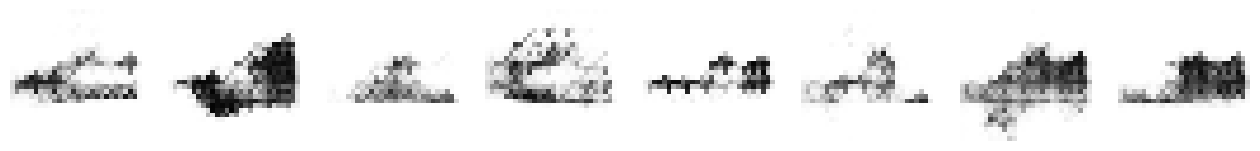

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - d_loss: 0.2230 - g_loss: 2.6561
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.2236 - g_loss: 2.5161
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: 0.2192 - g_loss: 2.5899
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - d_loss: 0.1608 - g_loss: 3.0037
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - d_loss: 0.2126 - g_loss: 2.6628
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1832 - g_loss: 3.1676
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.2063 - g_loss: 2.9237
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.2031 - g_loss: 2.8296
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1896 - g_loss: 2.9318
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.2063 - g_loss: 2.8323


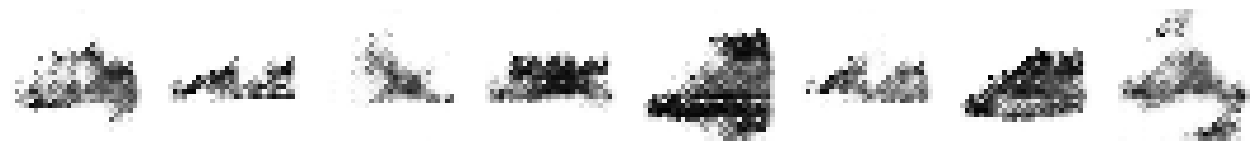

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - d_loss: 0.2067 - g_loss: 2.7403
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1537 - g_loss: 3.1005
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.2699 - g_loss: 2.5422
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1995 - g_loss: 2.7749
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1738 - g_loss: 3.1968
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - d_loss: 0.2208 - g_loss: 3.0154
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - d_loss: 0.2372 - g_loss: 2.9001
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.2115 - g_loss: 2.8198
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.2529 - g_loss: 2.6048


In [10]:
n_epochs = 100
for epoch in range(n_epochs):
    # train
    gan.fit(
    train_dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)
    if epoch%10 ==0:
      plot_reconstruction(gan)

# Upload this Colab Notebook to your Github repository. Also add your *reflections* on today's learning in README.md